In [20]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import VarianceThreshold,mutual_info_classif,SelectKBest,SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import  GridSearchCV,cross_val_score,TimeSeriesSplit

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_auc_score,roc_curve, auc,matthews_corrcoef

In [21]:
X_train=pd.read_csv('X_train2.csv')
Y_train=pd.read_csv('Y_train2.csv')
X_test=pd.read_csv('X_test2.csv')
Y_test=pd.read_csv('Y_test2.csv')

In [22]:
#embedded feature selection with RandomForestClassifier
sel_ = SelectFromModel(RandomForestClassifier())
sel_.fit(X_train, Y_train.values.ravel())

SelectFromModel(estimator=RandomForestClassifier())

In [23]:
sel_.get_support()

array([False, False, False,  True, False,  True, False, False,  True,
        True,  True, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False,  True,  True,  True,  True,
        True, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False, False])

In [24]:
# number of features selected
features_emrf = X_train.columns[(sel_.get_support())]
len(features_emrf)

22

In [25]:
# list of selected features
features_emrf

Index(['addr1', 'C1', 'D1', 'D2', 'D4', 'D8', 'D10', 'V127', 'V202', 'V203',
       'V263', 'V264', 'V279', 'V313', 'V314', 'LogAmt', 'day', 'Hour',
       'Logcard1', 'Logcard2', 'Logcard5', 'P_emaildomain_bin'],
      dtype='object')

In [26]:
X_train_=pd.DataFrame(X_train[features_emrf])
X_est_=pd.DataFrame(X_test[features_emrf])

RESAMPLING

In [27]:
#Resampling of training set (SMOTE and Random Undersampling)
pipe = make_pipeline(
    SMOTE(sampling_strategy=0.2),
    RandomUnderSampler(sampling_strategy=0.9)           
)

In [28]:
X_train_.var()
Y_train.var()

isFraud    0.033901
dtype: float64

In [29]:
X_emtrain,Y_emtrain=pipe.fit_resample(X_train_,Y_train)

In [30]:
X_emtrain=pd.DataFrame(X_emtrain)
Y_emtrain=pd.DataFrame(Y_emtrain)

In [32]:
train_em_=pd.concat([X_emtrain,Y_emtrain],axis=1)
# Shuffle dataframe rows
trainem = train_em_.sample(frac=1, random_state=60)

In [33]:
X_emtrain = trainem.drop('isFraud', axis=1)
Y_emtrain=trainem['isFraud']

In [35]:
X_emtest=X_est_
Y_emtest=Y_test

In [36]:
X_emtrain.shape,Y_emtrain.shape,X_emtest.shape,Y_emtest.shape

((192461, 22), (192461,), (118108, 22), (118108, 1))

In [37]:
#Random forest

In [38]:
# with default paramter
clf = RandomForestClassifier()
clf.fit(X_emtrain,Y_emtrain)
y_trainpred=clf.predict_proba(X_emtrain)
y_testpred = clf.predict_proba(X_emtest)

In [39]:
# auc with default parameters
print('train auc with default parameter:',roc_auc_score(Y_emtrain,y_trainpred[:,1]))
print('test auc with default parameter:',roc_auc_score(Y_emtest,y_testpred[:,1]))

train auc with default parameter: 0.9999999995668493
test auc with default parameter: 0.8521826879586053


In [40]:
#GridSearchCV with timeseries

time_splitter_outer = TimeSeriesSplit(n_splits = 3)
time_splitter_inner = TimeSeriesSplit(n_splits = 3)

model=RandomForestClassifier()
params = {'n_estimators':[500,700,900,1000],
           'max_depth':[3,5,7,9,11,13]}

gs_rf = GridSearchCV(model, param_grid = params, cv = time_splitter_inner, scoring = 'roc_auc',verbose=10, n_jobs=-1)


In [41]:
gs_rf.fit(X_emtrain,Y_emtrain)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed: 16.5min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 20.4min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9, 11, 13],
                         'n_estimators': [500, 700, 900, 1000]},
             scoring='roc_auc', verbose=10)

In [42]:
forest_scores = cross_val_score(gs_rf, X_emtrain,Y_emtrain, cv = time_splitter_outer, scoring = 'roc_auc').mean()
print(forest_scores)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed:  3.8min remaining:   24.3s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  4.6min finished


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed:  7.8min remaining:   50.4s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  9.5min finished


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed: 12.2min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 15.0min finished


0.9474550899114081


In [43]:
# Best values of the hyperparameters
max_depth_best = gs_rf.best_estimator_.max_depth
n_estimators_best = gs_rf.best_estimator_.n_estimators

In [44]:
rfc = RandomForestClassifier(max_depth = max_depth_best, n_estimators = n_estimators_best)
rfc.fit(X_emtrain,Y_emtrain)

RandomForestClassifier(max_depth=13, n_estimators=900)

In [45]:
#auc score after parameter tuning 
y_trainpredrffilter=rfc.predict_proba(X_emtrain)
y_testpredrffilter =rfc.predict_proba(X_emtest)
print('train auc:',roc_auc_score(Y_emtrain,y_trainpredrffilter[:,1]))
print('test auc:',roc_auc_score(Y_emtest,y_testpredrffilter[:,1]))

train auc: 0.9629196093183278
test auc: 0.8458525640797708


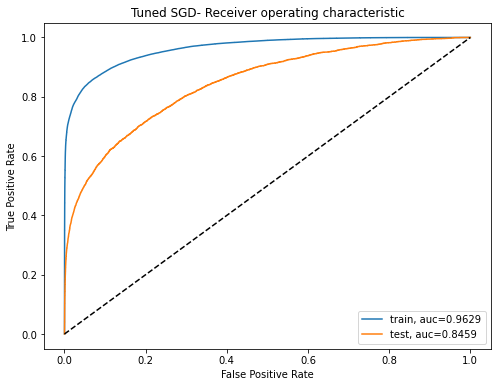

In [46]:
plt.figure(figsize=(8,6))
# auc of train
fpr, tpr, thresh = roc_curve(Y_emtrain,y_trainpredrffilter[:,1])
auc = roc_auc_score(Y_emtrain, y_trainpredrffilter[:,1])
plt.plot(fpr,tpr,label="train, auc="+str(round(auc,4)))
# auc of test
fpr, tpr, thresh = roc_curve(Y_emtest,  y_testpredrffilter[:,1])
auc = roc_auc_score(Y_emtest,  y_testpredrffilter [:,1])
plt.plot(fpr,tpr,label="test, auc="+str(round(auc,4)))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned SGD- Receiver operating characteristic')
plt.show()

In [47]:
y_trainpred_=rfc.predict(X_emtrain)
y_testpred_ = rfc.predict(X_emtest)

In [48]:
print("Accuracy:\n",metrics.accuracy_score(Y_emtest,y_testpred_))
print("Recall:\n",metrics.recall_score(Y_emtest,y_testpred_))

Accuracy:
 0.9343736241406171
Recall:
 0.5022145669291339


In [49]:
#confusion matrix
cm_train = confusion_matrix(Y_emtrain,y_trainpred_)
cm_test  =confusion_matrix(Y_emtest,y_testpred_)

Text(0.5, 1.0, 'test')

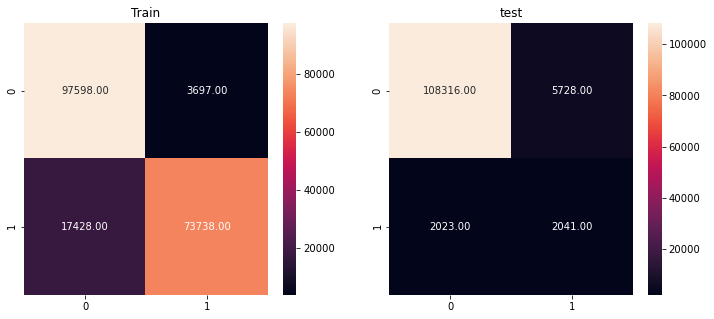

In [50]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm_train,annot=True,fmt='.2f')
plt.title('Train')
plt.subplot(1,2,2)
sns.heatmap(cm_test,annot=True,fmt='.2f')
plt.title('test')

In [51]:
#matthews correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(Y_emtrain, y_trainpred_)
matthews_corrcoef(Y_emtest, y_testpred_)

0.33234811333976916